In [1]:
# General scientific libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm, LinearSegmentedColormap, Normalize, SymLogNorm
from matplotlib import cm as colormap
import time
from string import ascii_lowercase
from scipy import signal
from scipy import fftpack
from scipy.constants import mu_0, epsilon_0
# Machine Epssilon for float
import ipywidgets
import time
from PIL import Image
import os
eps = np.finfo(float).eps

In [2]:
from masa_utils import PsuedoLog
from masa_utils import InducedPolarization
# FFT with various c

In [3]:
def plot_pelton(freq=None,res0=None, con8=None, eta=0.1, tau=1e-3, c=0.8, ax=None):
    # Assuming `cc` is your complex array, `freq` is the frequency array, and `tau` is defined
    if ax is None:
        fig, ax = plt.subplots(2, 1, figsize=(11, 5),dpi=300)
    if res0 is None and con8 is None:
        raise ValueError('Error: either res0 or con8 must be set')
    elif res0 is not None and con8 is not None:
        raise ValueError('Error: both sigma0 or sigmaInf are set')
    if freq is None:
        nfreq = 2**16
        freqcen = 1 / tau
        freqend = freqcen * nfreq**0.5
        freqstep = freqend / nfreq
        freq = np.arange(0, freqend, freqstep)
    PL_pelton = PsuedoLog(
                logmin=1e-7,
                linScale=0.2,
                logminx=10.**np.floor(np.log10(freq[1])),
                linScalex=0.2)
    IPmodel_f = InducedPolarization(con8=con8, res0=res0, eta=eta, tau=tau, c=c)
    if con8 is None:
        fft_f = IPmodel_f.pelton_res_f(freq, res0, eta, tau, c)
        ax[0].set_title(f''' Pelton model in resistivity form
            res0={res0:10.2e}, eta={eta:8.3f}, tau={tau:10.2e}, c={c:8.3f}''')
    if res0 is None:
        fft_f = IPmodel_f.pelton_con_f(freq, con8, eta, tau, c)
        ax[0].set_title(f''' Pelton model in conductivity form
             con8={con8:10.2e}, eta={eta:8.3f}, tau={tau:10.2e}, c={c:8.3f}''')
    ax[0] = PL_pelton.semiplx(x=freq, y=fft_f.real, ax=ax[0], yscale_log=False,
                              label='Real', color="C0")
    ax[0] = PL_pelton.semiplx(x=freq, y=fft_f.imag, ax=ax[0], yscale_log=False,
                              label='Imaginary', color="C1")
    ax[0] = PL_pelton.semiplx(x=freq, y=np.abs(fft_f), ax=ax[0], yscale_log=False,
                              label='Absolute Value', color="C2")
    PL_pelton.pl_axes_x(ax=ax[0])
    ax[1] = PL_pelton.semiplx(x=freq, y=np.degrees(np.angle(fft_f)), ax=ax[1], yscale_log=False,
                              label='Phase (degrees)', color="C0")
    PL_pelton.pl_axes_x(ax=ax[1])

   # Shared x-axis label and vertical line
    for a in ax:
        a = PL_pelton.pl_axvline(ax=a, x=1/tau,color="C3",label=r'$1/\tau$')
#        a = PL_pelton.pl_axvline(ax=a, x=1/tau/2/np.pi,label=r'$1/\tau $')
        a.set_xlabel('Frequency [Hz]')
        a.set_ylabel('Amplitude')
        a.grid(which='both')
        a.legend()
    ax[1].set_ylabel('Phase [Degrees]')
    return ax 

In [4]:
res0min, res0max = 1.0e-3, 1.0e6
log10res0min, log10res0max = np.log10(res0min), np.log10(res0max)
con8min, con8max = 1.0e-6, 1.0e3
log10con8min, log10con8max = np.log10(con8min), np.log10(con8max)
etamin, etamax = 0, 0.99
taumin, taumax = 1.0e-4, 1.0
log10taumin, log10taumax = np.log10(taumin), np.log10(taumax)
cmin, cmax = 0., 1.0
res0_default, eta_default, tau_default, c_default = 200, 0.5,  0.1, 1.
con8_default = 1 / (res0_default * (1 - eta_default))


In [5]:
#  Widget for the main function
def plot_pelton_widget(conductivity_or_resistivity,
         res0=None, con8=None, eta=None, tau=None, c=None):
    # Clear the current output to avoid duplicate figures
    
    # Create the plot
    fig, ax = plt.subplots(2, 1, figsize=(11, 6),dpi=300)


    if conductivity_or_resistivity == "Resistivity":
        ax=plot_pelton(freq=None, res0=res0, eta=eta, tau=tau, c=c, ax=ax)
    else:
        ax=plot_pelton(freq=None, con8=con8, eta=eta, tau=tau, c=c, ax=ax)
    plt.tight_layout()
    return ax

conductivity_or_resistivity = ipywidgets.ToggleButtons(
    options=["Resistivity", "Conductivity"],
    description="Mode:",
    disabled=False,
)
# Define sliders
res0_slider = ipywidgets.FloatLogSlider(
        base=10, min=np.log10(res0min), max=np.log10(res0max), step=0.01,
        value=res0_default, description="Resistivity (res0)")
con8_slider = ipywidgets.FloatLogSlider(
        base=10, min=np.log10(con8min), max=np.log10(con8max), step=0.01,
        value=con8_default, description="Conductivity (con8)")
eta_slider = ipywidgets.FloatSlider(
       min=etamin, max=etamax, step=0.01,
       value=eta_default, description="Chargeability")
tau_slider = ipywidgets.FloatLogSlider(
        base=10, min=np.log10(taumin), max=np.log10(taumax), step=0.01, 
        value=tau_default, description="Time constant(sec)")
c_slider = ipywidgets.FloatSlider(
        min=cmin, max=cmax, step=0.01,
        value=c_default, description="Exponent C")
# Function to update sliders
def update_sliders(mode):
    if mode == "Resistivity":
        return ipywidgets.VBox([res0_slider, eta_slider, tau_slider, c_slider])
    else:
        return ipywidgets.VBox([con8_slider, eta_slider, tau_slider, c_slider])


slider_container = ipywidgets.interactive_output(update_sliders, {'mode': conductivity_or_resistivity})
interactive_plot = ipywidgets.interactive(
    plot_pelton_widget,
    conductivity_or_resistivity=conductivity_or_resistivity,
    res0=res0_slider,
    con8=con8_slider,
    eta=eta_slider,
    tau=tau_slider,
    c=c_slider,
)

# Display all widgets
display(conductivity_or_resistivity, slider_container, interactive_plot)

ToggleButtons(description='Mode:', options=('Resistivity', 'Conductivity'), value='Resistivity')

Output()

interactive(children=(ToggleButtons(description='Mode:', options=('Resistivity', 'Conductivity'), value='Resis…

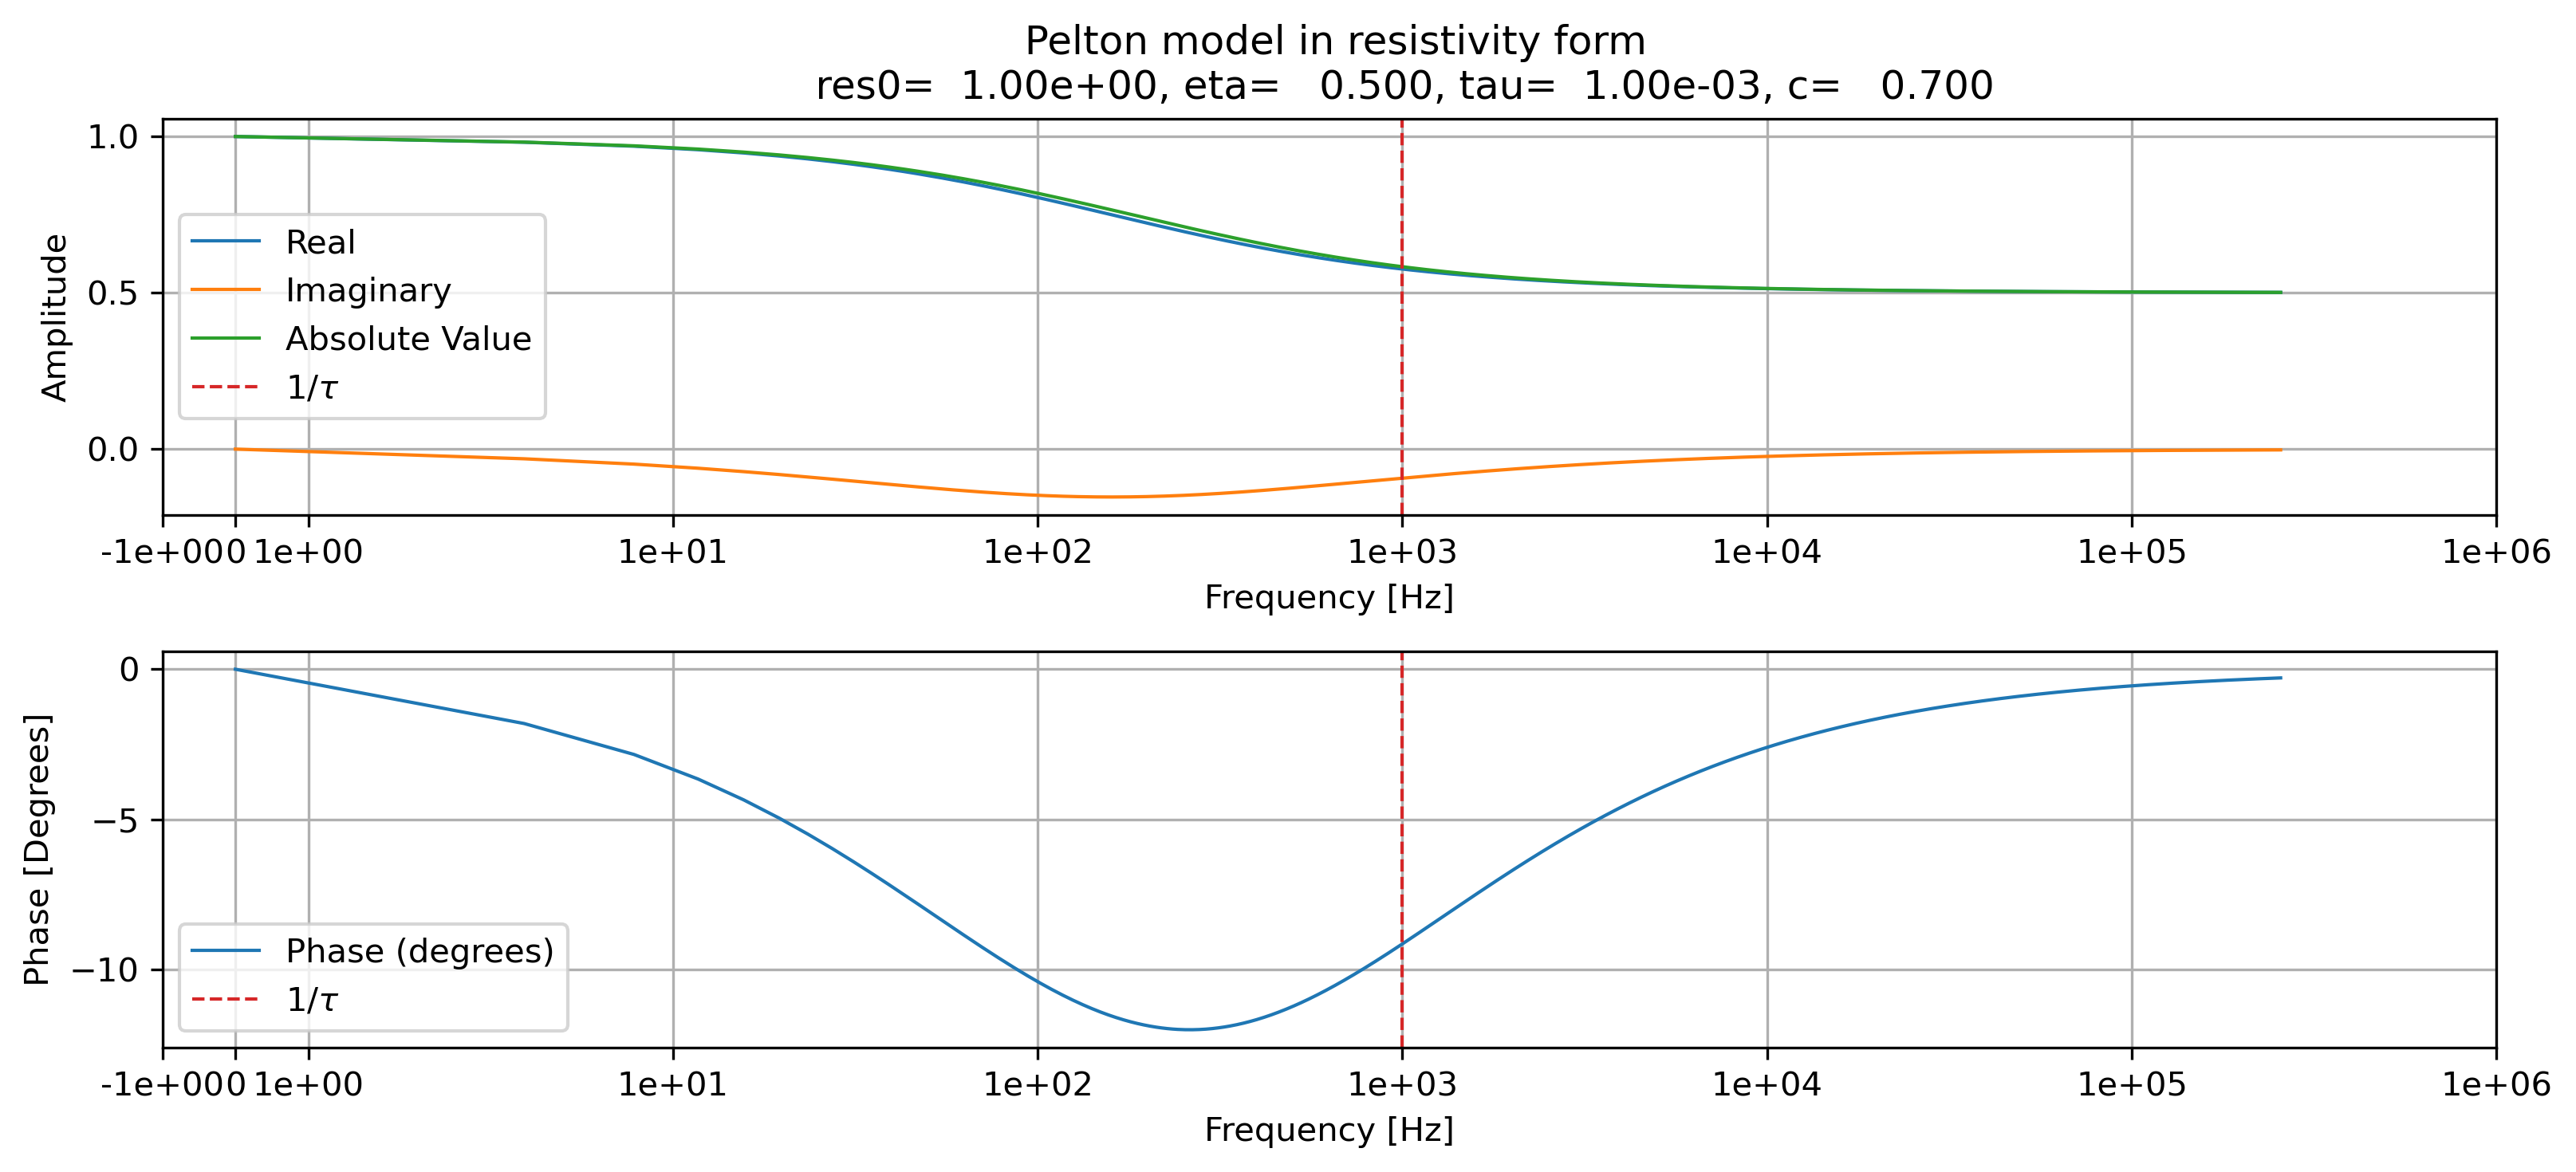

In [6]:
res0 = 1.0
con8=None
# con8 = 1 / (res0 * (1 - 0.5))
# res0= None
# con8 = 0.1
eta = 0.5
tau = 1e-3
c = 0.7
plot_pelton(freq=None,res0=res0,con8=con8,eta=eta, tau=tau, c=c)
plt.tight_layout()
plt.show()

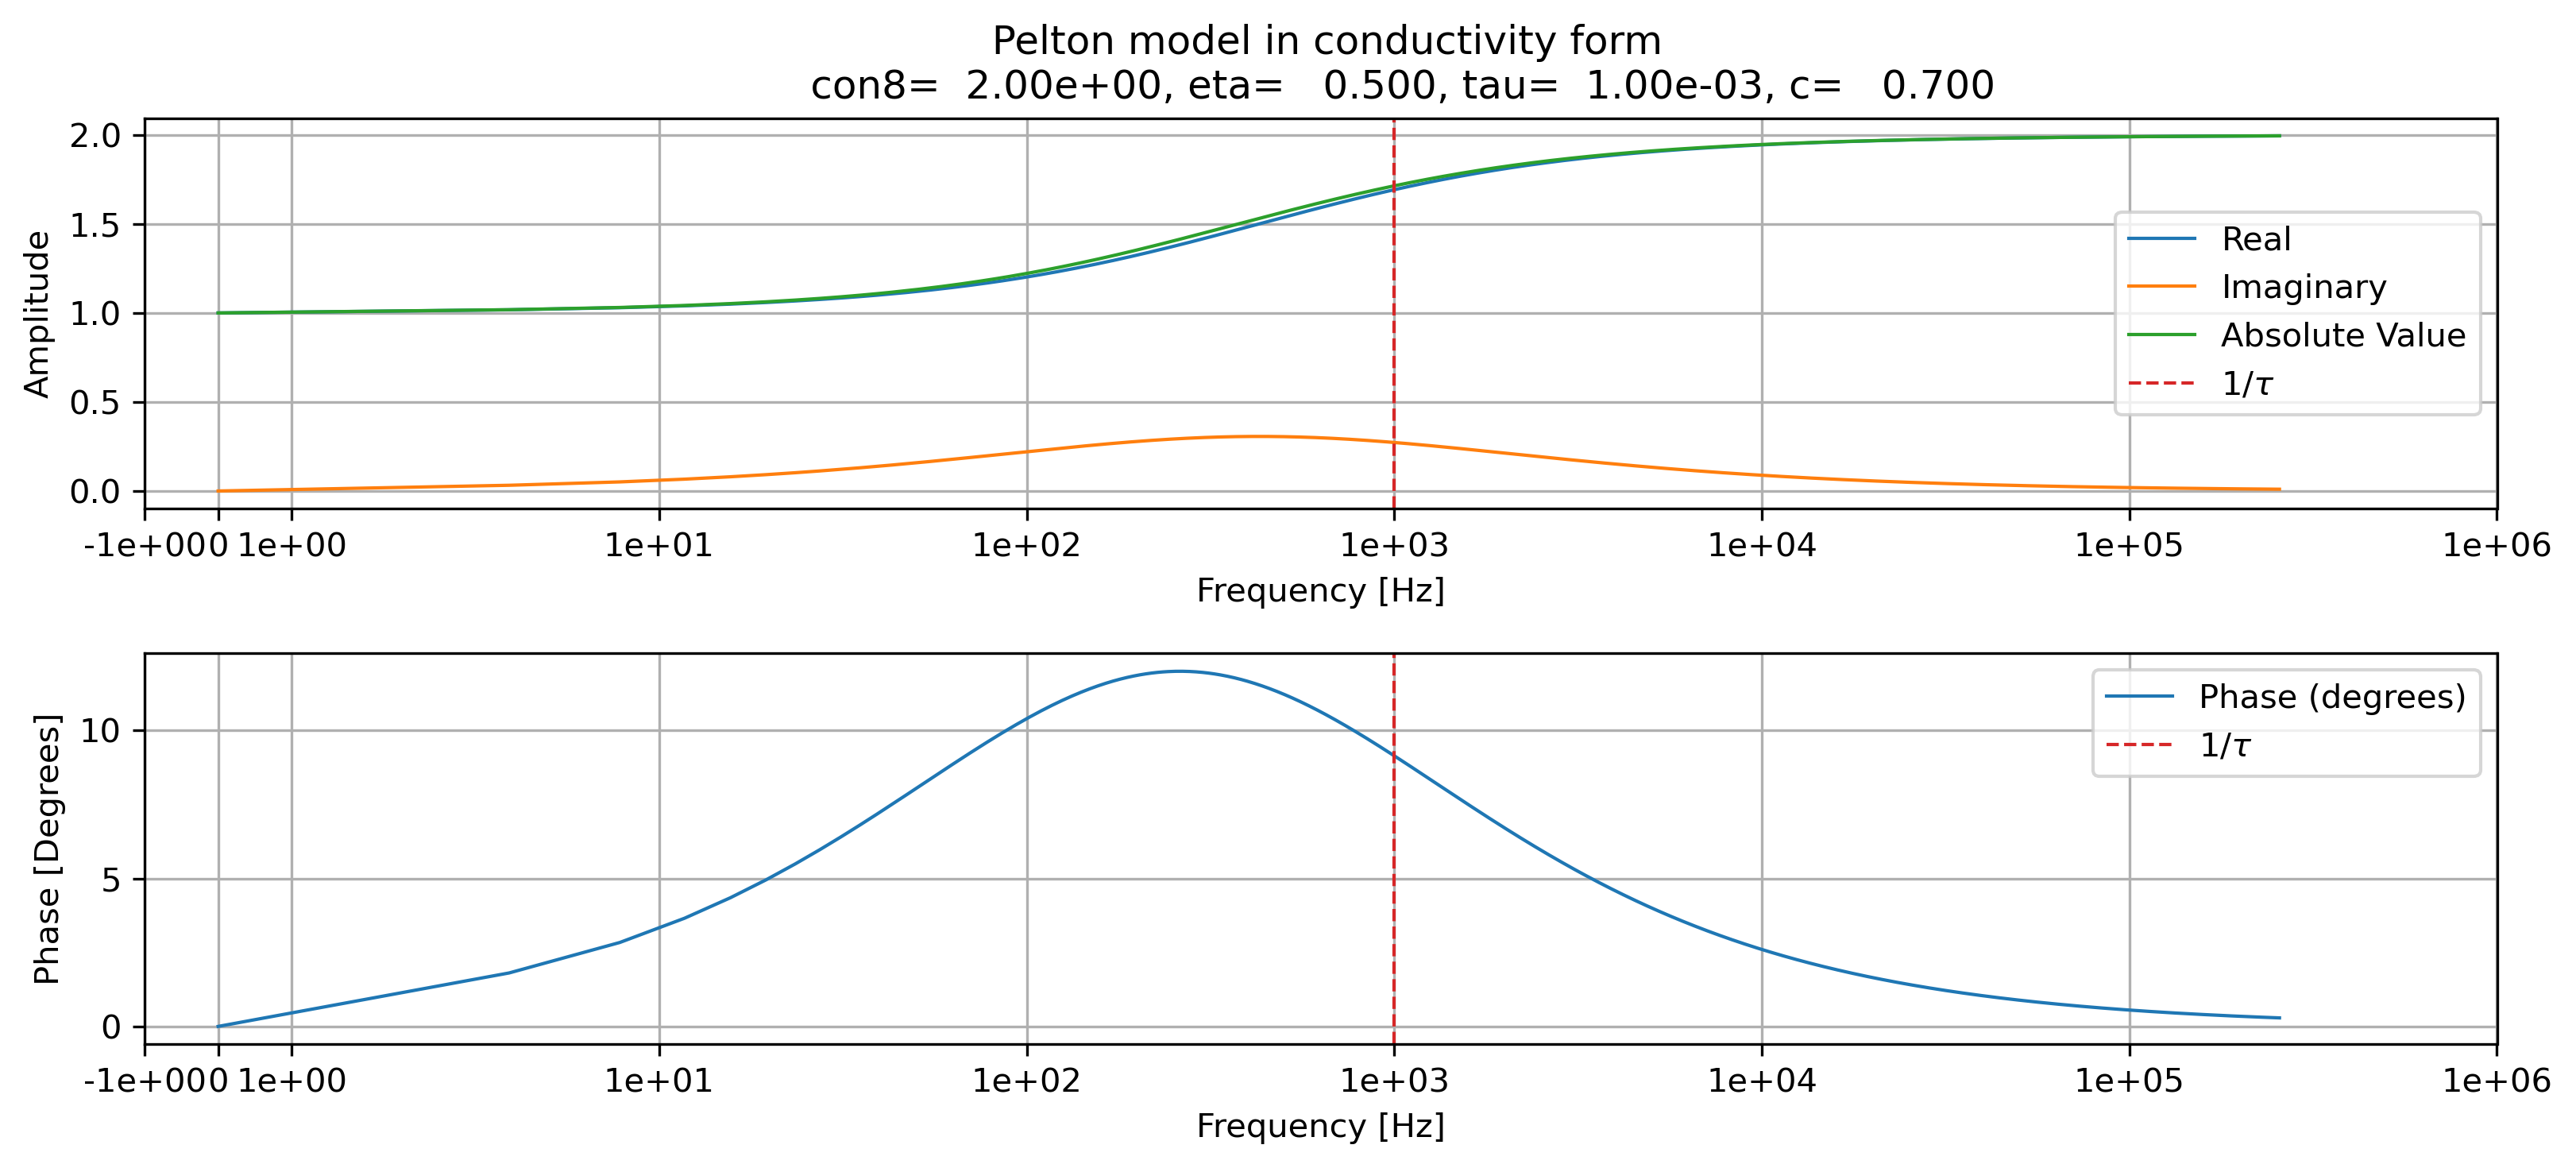

In [7]:
con8 = 1 / (res0 * (1 - 0.5))
res0 = None
# res0= None
# con8 = 0.1
plot_pelton(freq=None,res0=res0,con8=con8,eta=eta, tau=tau, c=c)
plt.tight_layout()

plt.show()

# FFT with various c

In [8]:
def plot_fft(con_form,res0=None, con8=None,log2nfreq=16, eta=0.1, tau=1e-3, c=0.8, ax=None):
    # Assuming `cc` is your complex array, `freq` is the frequency array, and `tau` is defined
    if ax is None:
        fig, ax =plt.subplots(2, 1, figsize=(11, 6),dpi=300)

    IPmodel_fft = InducedPolarization(con8=con8, res0=res0,eta=eta, tau=tau, c=c)
    freq_tau=IPmodel_fft.get_frequency_tau(log2nfreq=log2nfreq)
    times_tau, data_tau = IPmodel_fft.pelton_fft(con_form=con_form, freq=freq_tau)
    time_step = times_tau[1] - times_tau[0]
    data_tau *= time_step
    data_tau_intg = np.cumsum(data_tau)

    if con_form:
        ax[0].set_title(
        fr"$\sigma(t)dt$, Time step: {time_step:.2e}, ntimestep: {len(times_tau)}, "
        fr"$\sigma_\infty$: {con8:.2e}, $\eta$: {eta:.3f}, $\tau$: {tau:.2e}, $c$: {c:.3f}" )
        ax[1].set_title('Conductivity Integrated over time')
    else:
        ax[0].set_title(
        fr"$\rho(t)dt$, time step: {time_step:.2e}, ntimesetp {len(times_tau)}, "
        fr"$\rho_0$: {res0:10.2e}, $\eta$: {eta:8.3f}, $\tau$: {tau:10.2e}, c={c:8.3f}")
        ax[1].set_title('Resistivity Integrated over time')

    PL_fft = PsuedoLog(
                logmin=10.**np.floor(np.log10(data_tau.max())-3.),
                linScale=0.5,
                logminx=10.**np.ceil(np.log10(time_step)),
                linScalex=0.2)
    ax[0] = PL_fft.plpl_plot(x=np.r_[0,times_tau[0]], y=np.r_[0,data_tau[0]], ax=ax[0], 
                             label='t=0', color="C0",
                             marker='o', markersize=4) 
    ax[0] = PL_fft.plpl_plot(x=times_tau[1:], y=data_tau[1:], ax=ax[0], 
                                label='t>0', color="C0") 

    PL_fft.pl_axes(ax=ax[0])
    PL_fft.pl_axes_x(ax=ax[0])
    ax[1] = PL_fft.semiplx(x=times_tau, y=data_tau_intg, ax=ax[1], yscale_log=False,
                                label='', color="C0")
    PL_fft.pl_axes_x(ax=ax[1])
    ax[1].set_ylim(bottom=0)


    for a in ax:
        a = PL_fft.pl_axvline(ax=a, x=tau,color="C3",label=r'$\tau$')
        a.set_xlabel('time(sec)')
        a.set_ylabel('Amplitude')
        a.grid(which='both')
        a.legend()
    return ax 

In [9]:
res0_default, eta_default, tau_default, c_default = 0.15, 0.3,  1e-3, 0.8
con8_default = 1 / (res0_default * (1 - eta_default))

In [10]:
#  Widget for the main function
def plot_fft_widget(conductivity_or_resistivity, res0=None, con8=None, eta=None, tau=None, c=None):
    fig, ax = plt.subplots(2, 1, figsize=(11, 6),dpi=300)
    log2nfreq = 13

    if conductivity_or_resistivity == "Resistivity":
        con_form = False
        plot_fft(con_form=con_form,log2nfreq=log2nfreq,res0=res0, eta=eta, tau=tau, c=c, ax=ax)
    else:
        con_form = True
        plot_fft(con_form=con_form,log2nfreq=log2nfreq,con8=con8, eta=eta, tau=tau, c=c, ax=ax)
    plt.tight_layout()
    plt.show()

# ToggleButtons for selecting resistivity or conductivity
conductivity_or_resistivity = ipywidgets.ToggleButtons(
    options=["Resistivity", "Conductivity"],
    description="Mode:",
    disabled=False,
    button_style='info',
    value= "Conductivity"
)

res0_slider = ipywidgets.FloatLogSlider(
        base=10, min=np.log10(res0min), max=np.log10(res0max), step=0.01,
        value=res0_default, description="Resistivity (res0)")
con8_slider = ipywidgets.FloatLogSlider(
        base=10, min=np.log10(con8min), max=np.log10(con8max), step=0.01,
        value=con8_default, description="Conductivity (con8)")
eta_slider = ipywidgets.FloatSlider(
       min=etamin, max=etamax, step=0.01,
       value=eta_default, description="Chargeability")
tau_slider = ipywidgets.FloatLogSlider(
        base=10, min=np.log10(taumin), max=np.log10(taumax), step=0.01, 
        value=tau_default, description="Time constant(sec)")
c_slider = ipywidgets.FloatSlider(
        min=cmin, max=cmax, step=0.01,
        value=c_default, description="Exponent C")
# Function to update sliders
def update_sliders(mode):
    if mode == "Resistivity":
        return ipywidgets.VBox([res0_slider, eta_slider, tau_slider, c_slider])
    else:
        return ipywidgets.VBox([con8_slider, eta_slider, tau_slider, c_slider])


slider_container = ipywidgets.interactive_output(update_sliders, {'mode': conductivity_or_resistivity})
interactive_plot = ipywidgets.interactive(
    plot_fft_widget,
    conductivity_or_resistivity=conductivity_or_resistivity,
    res0=res0_slider,
    con8=con8_slider,
    eta=eta_slider,
    tau=tau_slider,
    c=c_slider,
)

# Display all widgets
display(conductivity_or_resistivity, slider_container, interactive_plot)



ToggleButtons(button_style='info', description='Mode:', index=1, options=('Resistivity', 'Conductivity'), valu…

Output()

interactive(children=(ToggleButtons(button_style='info', description='Mode:', index=1, options=('Resistivity',…

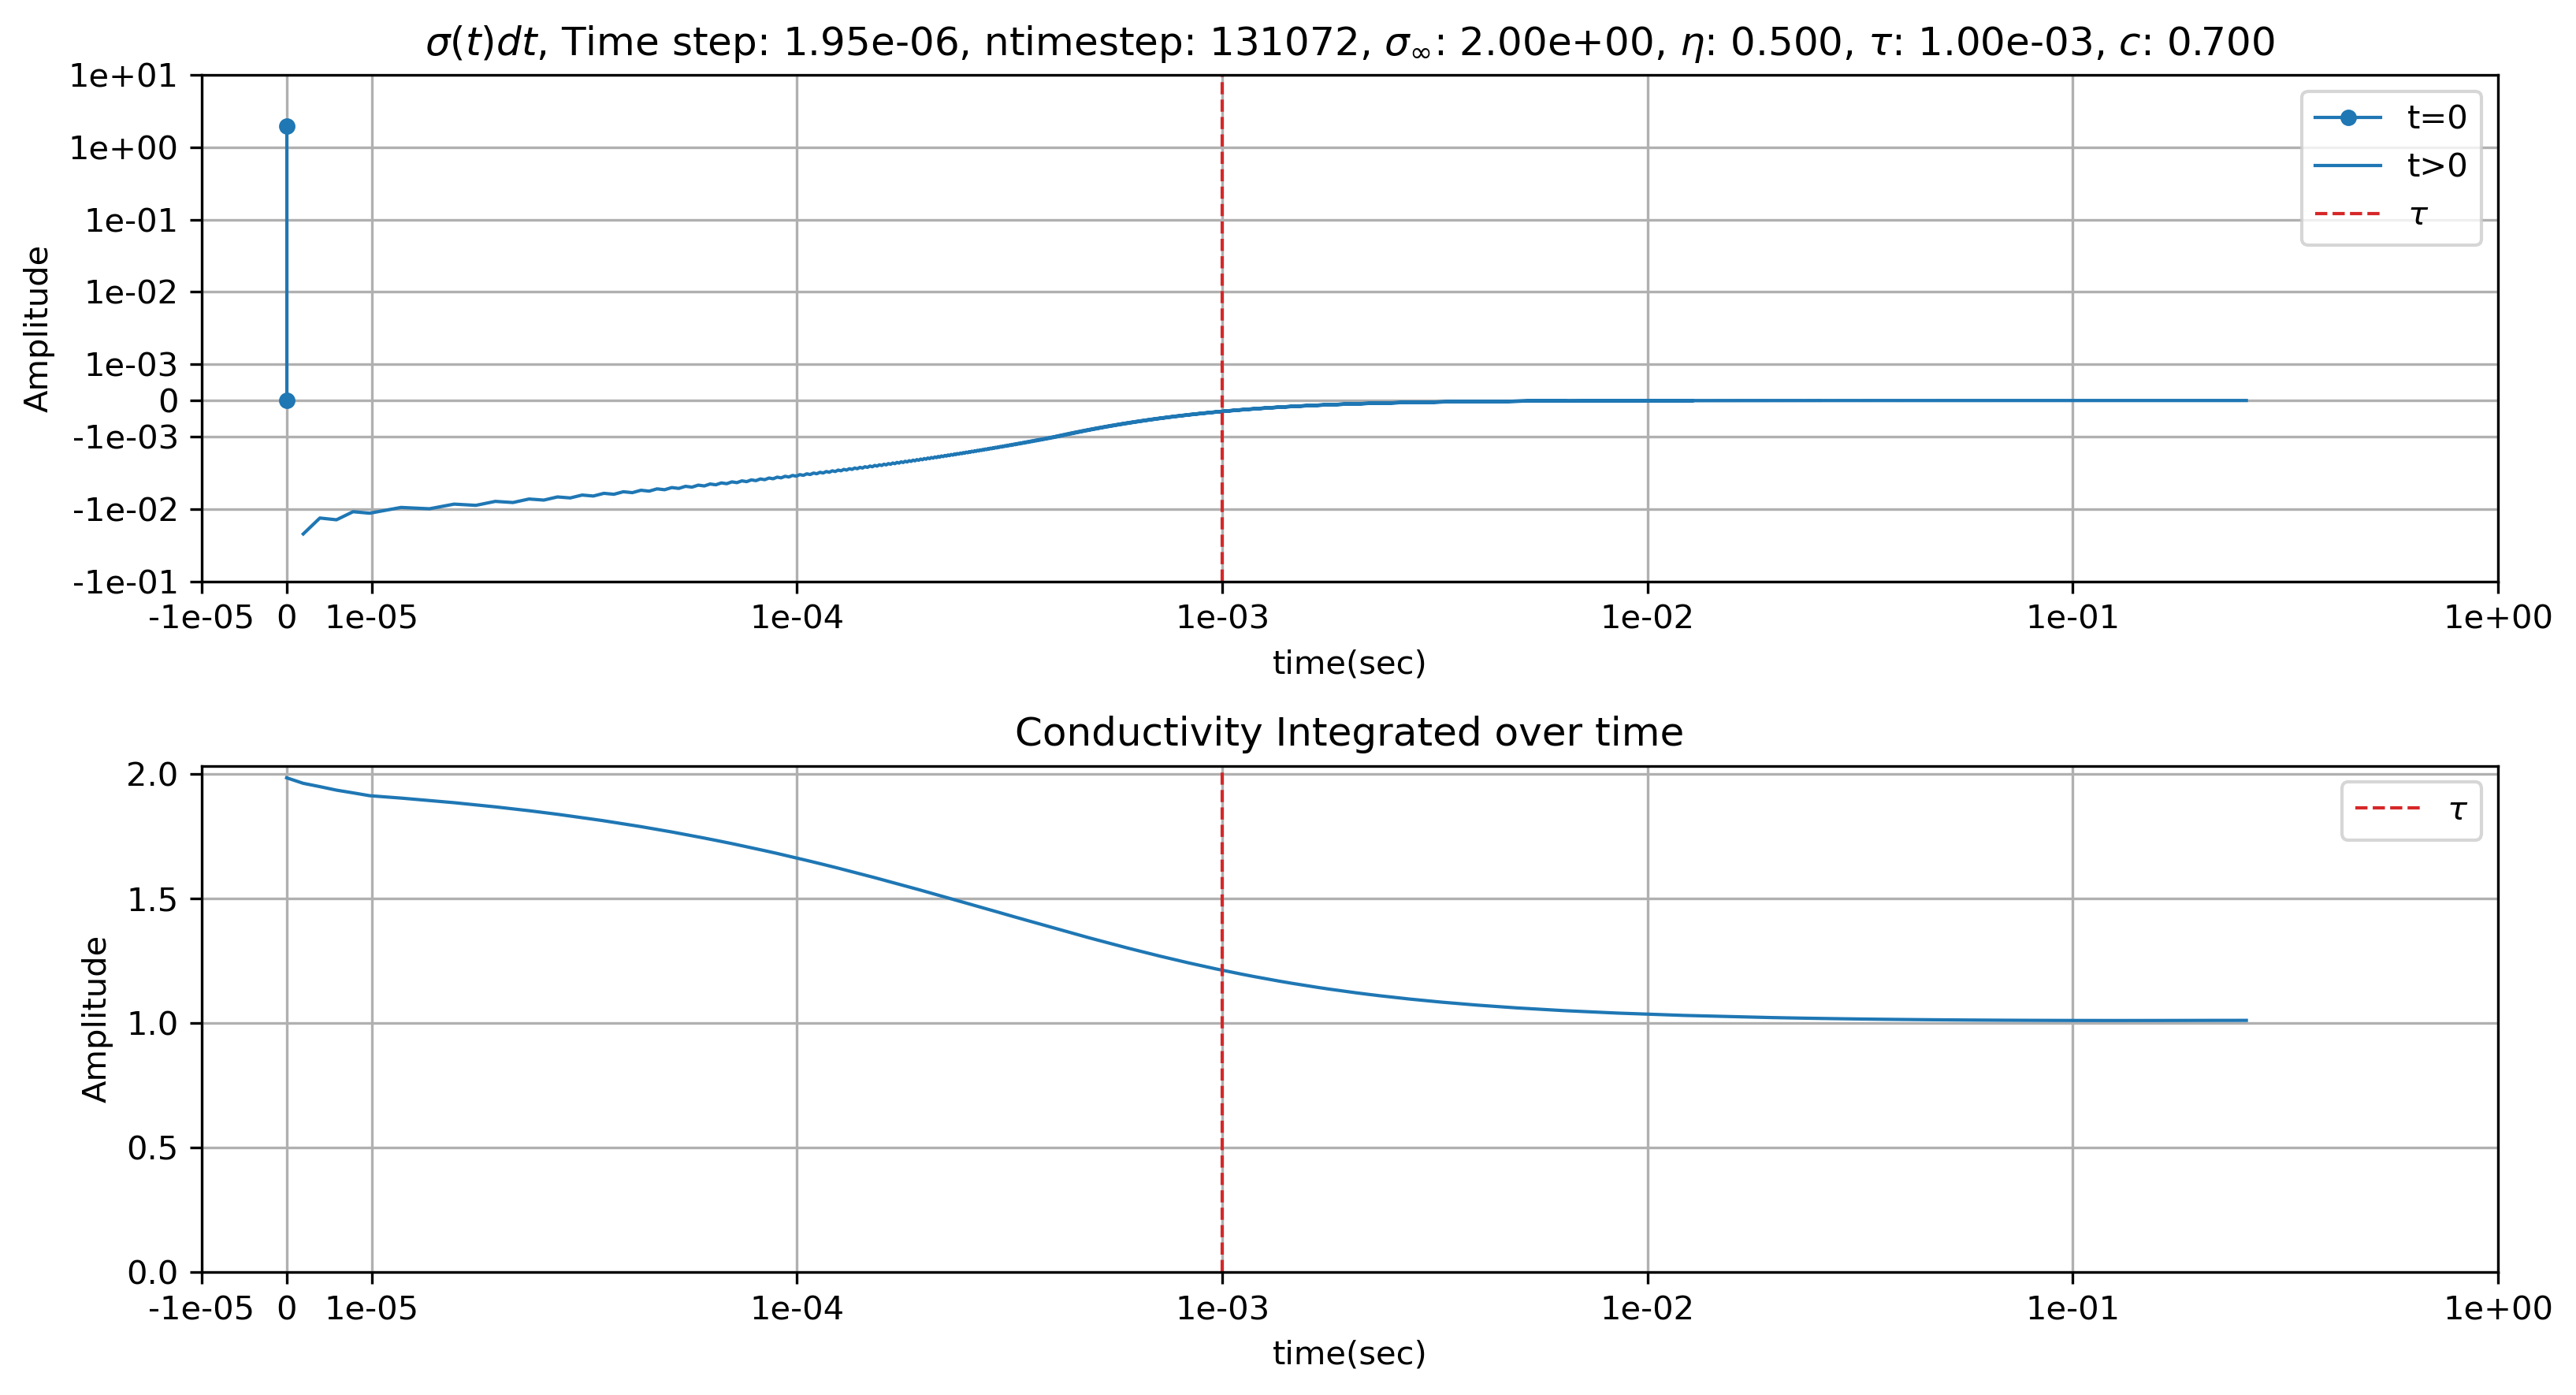

In [11]:
con_form = True
con8 = 2.0
res8 =1/con8
eta = 0.5
res0= res8/(1-eta) 
tau = 1e-3
c = 0.7
plot_fft(con_form=con_form,log2nfreq=18,con8=con8,eta=eta, tau=tau, c=c)
plt.tight_layout()
plt.show()

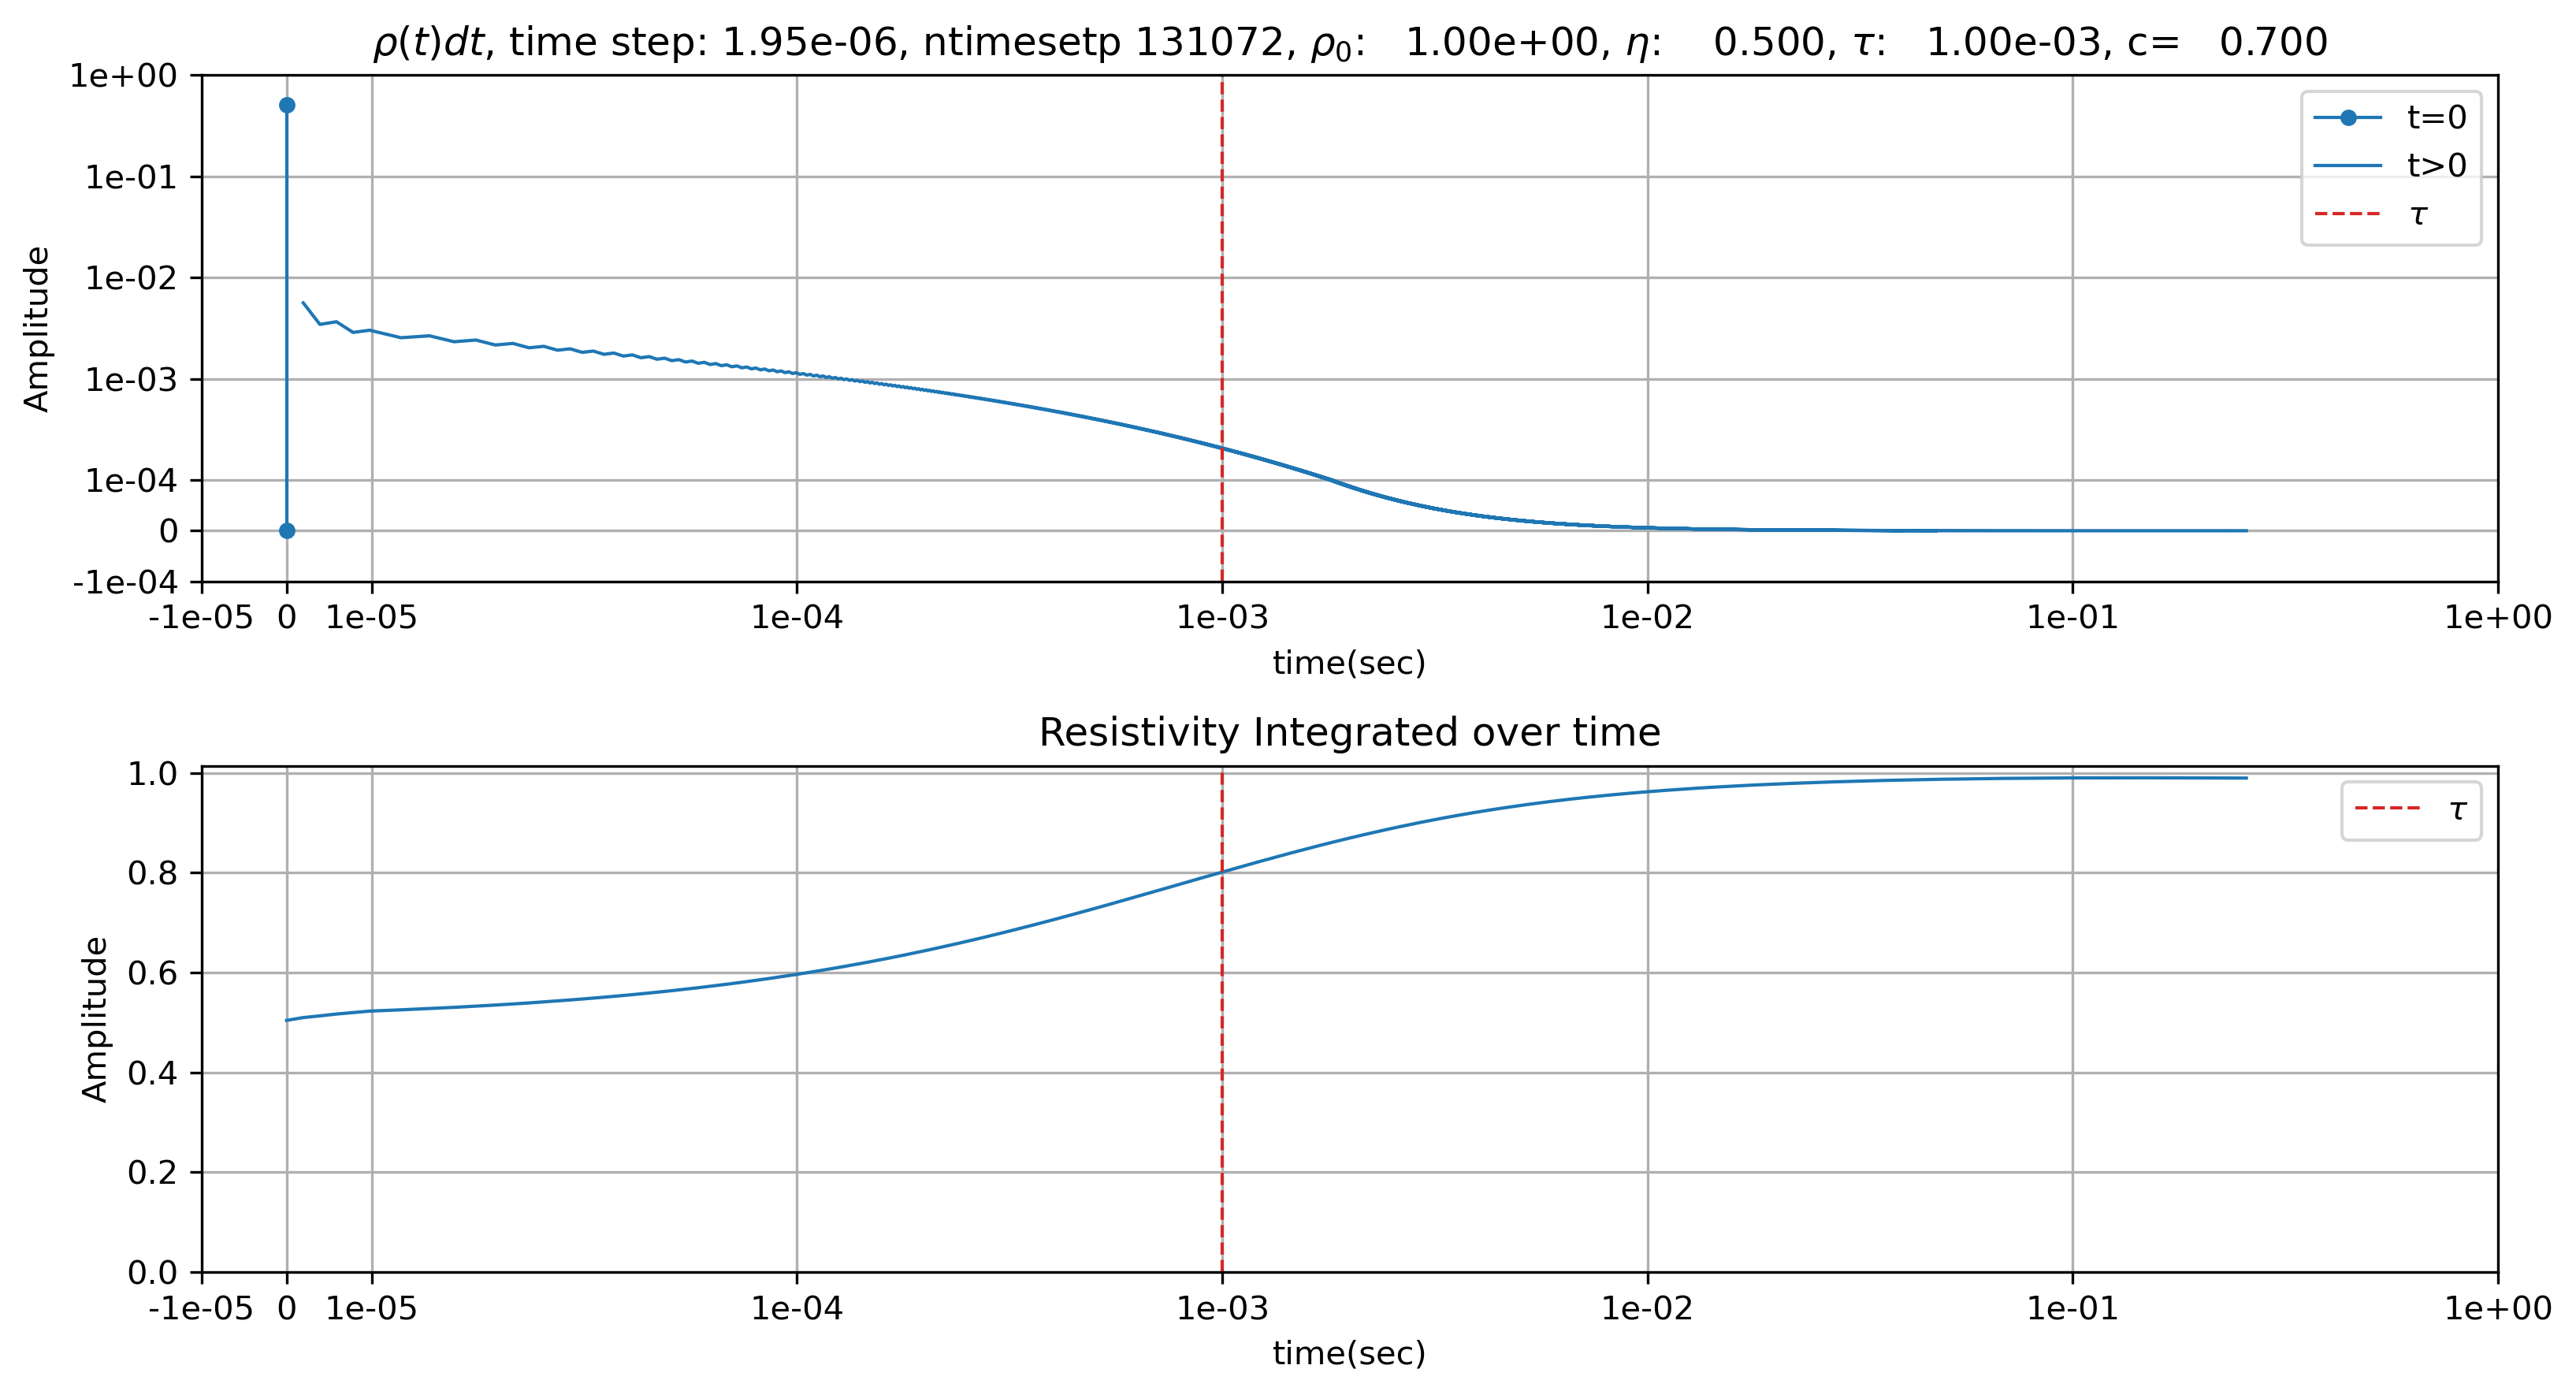

In [12]:
con_form = False
plot_fft(con_form=con_form,log2nfreq=18,res0=res0,eta=eta, tau=tau, c=c)
plt.tight_layout()
plt.show()

# Convolve with rectangular wave

In [13]:
res0, eta, tau, c = 0.15, 0.3,  1e-3, 0.8
con8 = 1/(res0*(1-eta))
IPmodel = InducedPolarization(con8=con8, res0=res0,eta=eta, tau=tau, c=c)

In [14]:
## Prepare function for waveform
def rect_wave(t, basefrq, neg=False):
    if neg:
        pos= 0.5*(1.0+signal.square(2*np.pi*(basefrq*t    ),duty=0.25))
        neg=-0.5*(1.0+signal.square(2*np.pi*(basefrq*t+0.5),duty=0.25))
        return pos + neg
    else :
        pos= 0.5*(1.0+signal.square(2*np.pi*(basefrq*t    ),duty=0.5))
        return pos


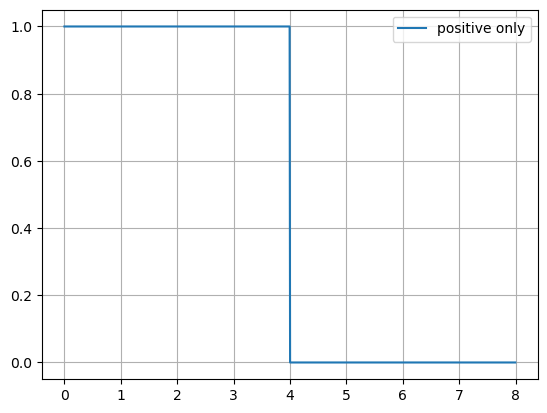

In [15]:
basefrq = 0.125
time_end = 1/basefrq
time_step = time_end/1000
times_smp = np.arange(0, time_end, time_step)
signal_smp = rect_wave(times_smp, basefrq)
plt.plot(times_smp,rect_wave(t=times_smp,basefrq=basefrq),label='positive only')
#plt.plot(times_smp,rect_wave(t=times_smp,basefrq=basefrq,neg=True),'--',label='Alternating')
plt.grid()
plt.legend()

In [16]:
def cnv_trans(basefrq,log2nfreq=16, con_form=False,con8=con8, res0=None,eta=None, tau=None, c=None):
    baseperiod = 1/basefrq
    freq_tau=IPmodel.get_frequency_tau(tau=tau,log2nfreq=log2nfreq)
    times_tau, data_tau = IPmodel.pelton_fft(con_form=con_form, freq=freq_tau,
            con8=con8,res0=res0,eta=eta,tau=tau, c=c)
    times_obs = times_tau[times_tau < baseperiod-eps]
    ntime = len(times_obs)
    time_step = times_tau[1] - times_tau[0]
    data_tau = data_tau[:ntime] *time_step
    signal_smp = rect_wave(t=times_obs, basefrq=basefrq)
    obs_smp = np.convolve(signal_smp, data_tau, mode='full')[:ntime]
    return times_obs, obs_smp

In [17]:
res0, eta, tau, c = 0.15, 0.3,  1e-3, 0.8
con8 = 1/(res0*(1-eta))
log2nfreq = 18
basefrq =4 # 125 #bfrq_tau*tau*float(ntime)
print(f'basefrq:{basefrq:10.2f}')
time_obs, data_obs = cnv_trans(basefrq=basefrq,log2nfreq=log2nfreq,
        con_form=False,res0=res0, eta=eta, tau=tau, c=c)
print(len(time_obs), len(data_obs))
hlf = int(len(time_obs))//2
print(f'end   of on-time  res0 {data_obs[hlf-1]:10.2e}')
print(f'start of off-time res8 {data_obs[hlf+1]:10.2e}')
print(f'eta calculated         {(data_obs[hlf+1]/data_obs[hlf-1]):10.2e}')
print(f'eta given              {eta:10.2e}')

basefrq:      4.00
128000 128000
end   of on-time  res0   1.49e-01
start of off-time res8   4.39e-02
eta calculated           2.94e-01
eta given                3.00e-01


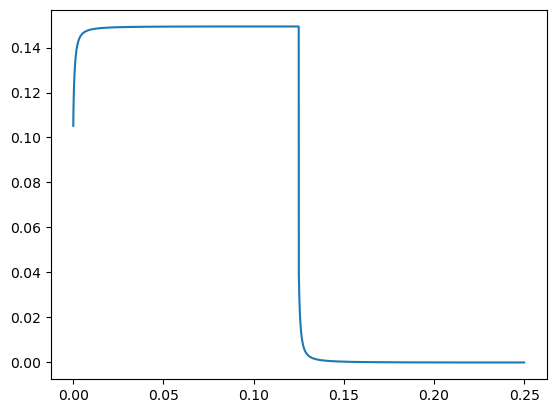

In [18]:
plt.plot(time_obs, data_obs)

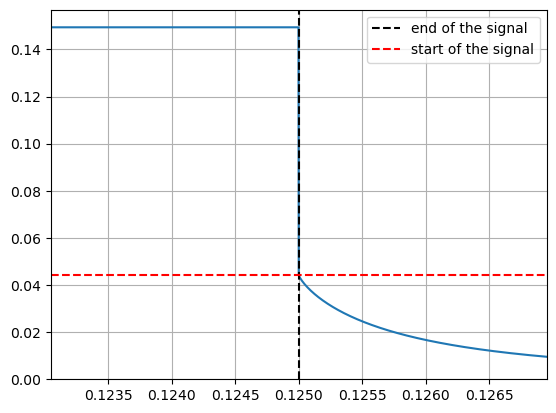

In [19]:
plt.plot(time_obs, data_obs)
plt.axvline(0.5/basefrq, color='k', linestyle='--', label='end of the signal')
plt.axhline(data_obs[-hlf], color='r', linestyle='--', label='start of the signal')
nxzoom = 1000
plt.xlim([time_obs[hlf-nxzoom],time_obs[-hlf+nxzoom]])
plt.ylim(bottom=0)
plt.grid()
plt.legend()

In [20]:
log10bfrqmin, log10bfrqmax = -1, 2
res0_default, eta_default, tau_default, c_default = 0.50, 0.5, 1e-3, 0.7
con8_default = 1 / (res0_default * (1 - eta_default))
basefrq_default = 10

# Convolution Animation

In [21]:
def cnv_sig_IP(basefrq=10,log2nfreq=16, con_form=False,con8=con8, res0=None,eta=None, tau=None, c=None):
    baseperiod = 1/basefrq
    freq_tau=IPmodel.get_frequency_tau(tau=tau,log2nfreq=log2nfreq)
    times_tau, data_tau = IPmodel.pelton_fft(con_form=con_form, freq=freq_tau,
            con8=con8,res0=res0,eta=eta,tau=tau, c=c)
    times_obs = times_tau[times_tau < baseperiod-eps]
    ntime = len(times_obs)
    time_step = times_tau[1] - times_tau[0]
    data_tau = data_tau[:ntime] *time_step
    signal_smp = rect_wave(t=times_obs, basefrq=basefrq)
    obs_smp = np.convolve(signal_smp, data_tau, mode='full')[:ntime]
    return times_obs, obs_smp, data_tau

In [26]:
def plot_dcip_conv(basefrq=10,con_form=True,ind_time=0,
            log2nfreq=16,con8=None,res0=None,eta=None,tau=None,c=None,ax=None):
    if ax is None:
        fig, ax = plt.subplots(3,1, figsize=(11,7))

    times_obs, data_obs, ip_obs = cnv_sig_IP(basefrq=basefrq,log2nfreq=log2nfreq,
        con_form=con_form,res0=res0, eta=eta, tau=tau, c=c)
   
    hlf = int(len(times_obs))//2
    eta_est = data_obs[hlf+1]/data_obs[hlf-1]
    ntime = len(times_obs)
    ax[0].plot(times_obs, rect_wave(t=times_obs,basefrq=basefrq))
    ax[0].plot(times_obs[ind_time], rect_wave(t=times_obs[ind_time],basefrq=basefrq),marker='o', color="C0")
    PL_fft = PsuedoLog(
                logmin=10.**np.floor(np.log10(ip_obs.max())-3.),
                linScale=0.5,
                logminx=10.**np.ceil(np.log10(time_step)),
                linScalex=0.2)
    ax[1] = PL_fft.semiply(x=np.repeat(times_obs[ind_time],2), y=np.r_[0,ip_obs[0]], ax=ax[1],
                            xscale_log=False, label='t=0', color="C0",  marker='o', markersize=4)
    ax[1] = PL_fft.semiply(x=times_obs[ind_time+1:],y=np.zeros(ntime- ind_time -1), ax=ax[1],
            xscale_log=False, color="C0")
    if ind_time >=2 :
        ax[1] = PL_fft.semiply(x=times_obs[:ind_time], y=ip_obs[ind_time:0:-1], ax=ax[1], 
                               xscale_log=False, label='t>0', color="C0") 
    ax[1]=PL_fft.pl_axes(ax=ax[1])

#    ax[1].plot(times_obs[0:ind_time+1], ip_obs[ind_time+1:0:-1])
    if con_form:
        ax[0].set_title('transmitter(V) in constant volatage mode')
        ax[1].set_title("Pelton in coductivity form "
            fr"$\sigma_\infty$:{con8:8.1e},$\eta$:{eta:6.2f},$\tau$:{tau:8.1e},c:{c:6.2f},"
            fr"bfrq:{basefrq:6.1f},$\eta$est:{eta_est:6.2f},ntime:{ntime}")
        ax[2].set_title("Data in current(A)")
    else:
        ax[0].set_title('transmitter(A) in constant current mode')
        ax[1].set_title("Pelton in resistivity form "
            fr"$\rho_0$:{res0:8.1e},$\eta$:{eta:6.2f},$\tau$:{tau:8.1e},c:{c:6.2f},"
            fr"bfrq:{basefrq:6.1f},$\eta$est:{eta_est:6.2f},ntime:{ntime}")
        ax[2].set_title("Data in voltage(V)")
    ax[2].plot(times_obs, data_obs, color="C0")
    ax[2].plot(times_obs[ind_time], data_obs[ind_time],
               marker='o', color="C0", label=f"time: {times_obs[ind_time]:.2e}")
    ax[2].axhline(data_obs[-hlf], color='C1', linestyle='--', 
                  label='amp at start start of decay')

    for a in ax:
        a.axvline(0.5/basefrq, color='k', linestyle='--', label='on time end')
        # a.axvline(tau+0.5/basefrq,label=r'$\tau$ after on time end', color='C1', linestyle='--')
        # a.axvline(x=tau,label=r'$\tau$ after on time start', color='C2', linestyle='--')
        a.set_xlabel('time(sec)')
        a.grid(which='both')
        a.legend()
    return ax, ntime

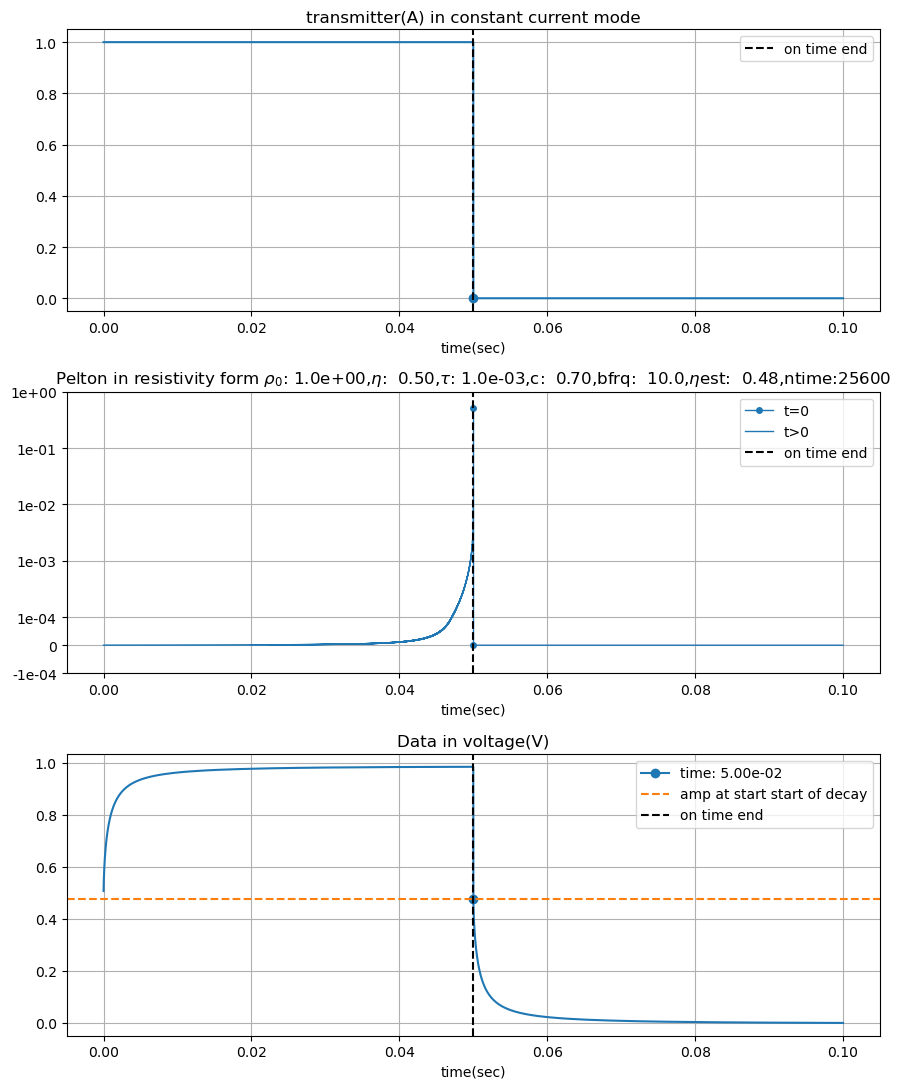

In [27]:
con_form = False
con8 = 2.0
res8 =1/con8
eta = 0.5
res0= res8/(1-eta) 
tau = 1e-3
c = 0.7
basefrq=10.0
log2nfreq=16
ind_time=12800
plot_dcip_conv(basefrq=basefrq,con_form=con_form,ind_time=ind_time,log2nfreq=log2nfreq,res0=res0,con8=con8,eta=eta, tau=tau, c=c)
plt.tight_layout()
plt.show()

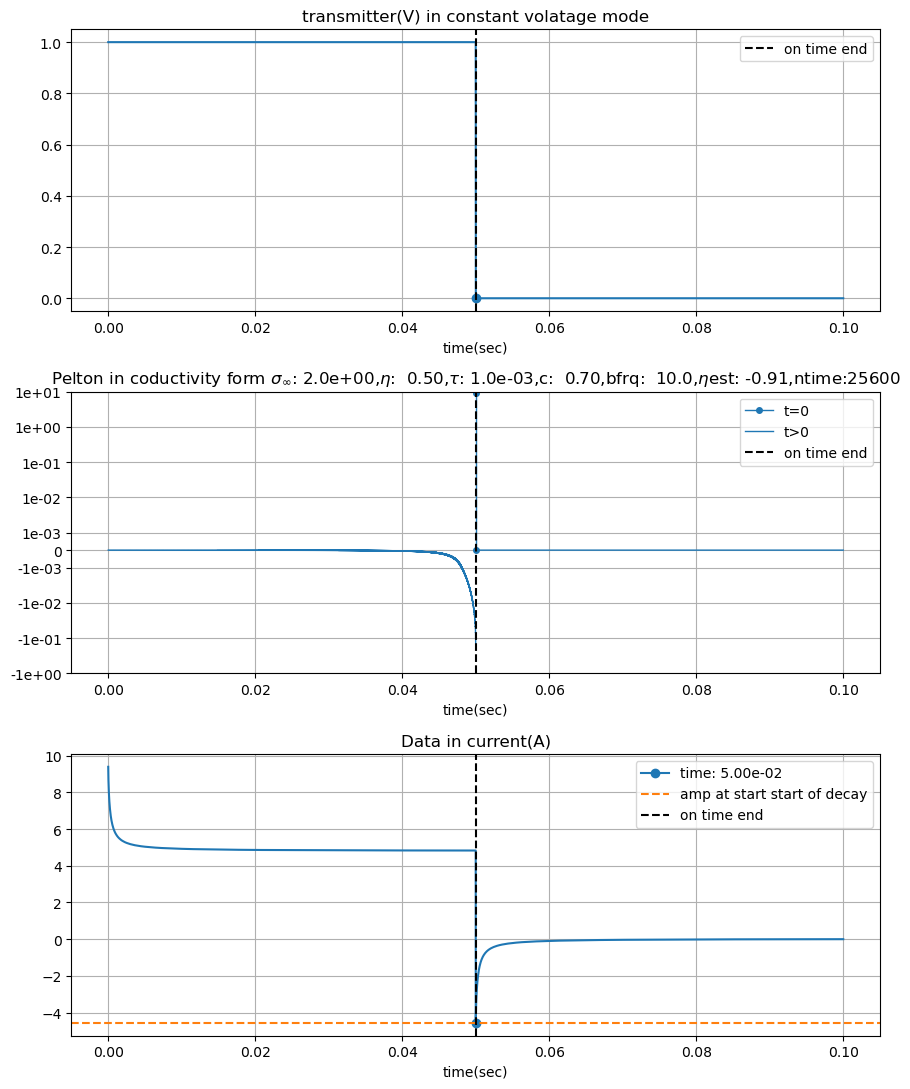

In [28]:
con_form = True
plot_dcip_conv(basefrq=basefrq,con_form=con_form,ind_time=ind_time,log2nfreq=log2nfreq,res0=res0,con8=con8,eta=eta, tau=tau, c=c)
plt.tight_layout()
plt.show()

In [25]:
# Widget for the main function
def plot_dcip_conv_widget(basefrq, ind_time, log2nfreq=16, con_form=True,
                          res0=None, con8=None, eta=None, tau=None, c=None, ax=None):
    # Use default values if not provided
    res0 = res0 if res0 is not None else res0_default
    con8 = con8 if con8 is not None else con8_default
    eta = eta if eta is not None else eta_default
    tau = tau if tau is not None else tau_default
    c = c if c is not None else c_default

    # Create the figure and axes
    fig, ax = plt.subplots(3, 1, figsize=(11, 7), dpi=300)
    ax, ntime = plot_dcip_conv(
        basefrq=basefrq,
        con_form=con_form,
        ind_time=ind_time,
        log2nfreq=log2nfreq,
        res0=res0,
        con8=con8,
        eta=eta,
        tau=tau,
        c=c,
        ax=ax,
    )
    plt.tight_layout()
    plt.show()

# ToggleButtons for switching con_form
con_form_toggle = ipywidgets.ToggleButtons(
    options=[True, False],
    value=True,
    description="Con Form:",
    disabled=False,
    button_style='',  # 'success', 'info', 'warning', 'danger' or ''
    tooltips=["True (Conductivity Form)", "False (Resistivity Form)"],
)

# Sliders for parameters
ind_time_slider = ipywidgets.IntSlider(min=10, max=2**16, step=20, description="ind_time")
basefrq_slider = ipywidgets.FloatLogSlider(
    base=10, min=log10bfrqmin, max=log10bfrqmax, value=basefrq_default, description="Base Frequency"
)
res0_slider = ipywidgets.FloatLogSlider(
    base=10, min=log10res0min, max=log10res0max, value=res0_default, description="Resistivity (res0)"
)
con8_slider = ipywidgets.FloatLogSlider(
    base=10, min=log10con8min, max=log10con8max, value=con8_default, description="Conductivity (con8)"
)
eta_slider = ipywidgets.FloatSlider(min=0, max=1, step=0.01, value=eta_default, description="eta")
tau_slider = ipywidgets.FloatLogSlider(
    base=10, min=log10taumin, max=log10taumax, value=tau_default, description="tau"
)
c_slider = ipywidgets.FloatSlider(min=0, max=1, step=0.01, value=c_default, description="c")

# Interactive output for the widget
interactive_output_widget = ipywidgets.interactive_output(
    plot_dcip_conv_widget,
    {
        "ind_time": ind_time_slider,
        "basefrq": basefrq_slider,
        "tau": tau_slider,
        "res0": res0_slider,
        "con8": con8_slider,
        "eta": eta_slider,
        "c": c_slider,
        "con_form": con_form_toggle,  # Add con_form toggle
    },
)

# Display sliders and output
ui = ipywidgets.VBox([
    con_form_toggle,
    ind_time_slider,
    basefrq_slider,
    tau_slider,
    res0_slider,
    con8_slider,
    eta_slider,
    c_slider,
])

display(ui, interactive_output_widget)


Output()

# Create Animation

In [49]:
def save_dcip_conv_widget(ind_time):
    fig, ax = plt.subplots(3,1, figsize=(11,7))
#    con_form = False
    con_form = True
    con8 = 2.0
    res8 =1/con8
    eta = 0.5
    res0= res8/(1-eta) 
    tau = 1e-3
    c = 0.7
    basefrq=10.0
    log2nfreq=16
    plot_dcip_conv(basefrq=basefrq,con_form=con_form,ind_time=ind_time,
            log2nfreq=log2nfreq,res0=res0,con8=con8,eta=eta, tau=tau, c=c,ax=ax)
    plt.tight_layout()



In [50]:
def save_all_images(index_list, output_folder='images'):
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    for ind_save in index_list:
        # Create a new figure and axes for each time index
        fig, ax = plt.subplots(3,1,figsize=(11, 7))
        
        # Plot the fields for the current time index
        save_dcip_conv_widget(ind_time=ind_save)

        # Create a filename with zero padding (e.g., 001.png, 002.png)
        filename = f'{ind_save:06d}.png'
        # Save the figure to the output folder
        filepath = os.path.join(output_folder, filename)
        plt.savefig(filepath, format='png', dpi=300, bbox_inches='tight', pad_inches=0.1)
        
        # Close the figure to avoid display issues and free up memory
        plt.close(fig)

In [ ]:
#index_list = np.arange(1, len(time_clc), 1)
index_list = np.arange(0, 25600, 400)
#index_list = np.arange(1,10, 1)

output_folder = 'images'
# set matplot lib not to show all images for VS code 
matplotlib.use('Agg')      

save_all_images(index_list, output_folder=output_folder)
%matplotlib inline
# set matplot lib not to show all images for VS code 


C:\Users\81805\AppData\Local\Temp\ipykernel_25996\3981661088.py:7: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed in 3.10.  To suppress this warning, explicitly call plt.close('all') first.
  matplotlib.use('Agg')


In [46]:
def images_to_gif(image_folder, output_gif, duration=1000, resize=(270, 330)):
    # Get all the image files in the folder
    image_files = sorted([f for f in os.listdir(image_folder) if f.endswith('.png') or f.endswith('.jpg')])

    # Open and resize the images
    images = [Image.open(os.path.join(image_folder, img)).resize(resize, Image.Resampling.LANCZOS) for img in image_files]
    # Just Open images  
    # images = [Image.open(os.path.join(image_folder, img)) for img in image_files]
    # Save the images as an animated GIF loop 0: infinite loop, 1: loop once
#    images[0].save(output_gif, save_all=True, append_images=images[1:], optimize=False, duration=duration, loop=0)
    images[0].save(output_gif, save_all=True, append_images=images, optimize=False, duration=duration, loop=1)


In [47]:
# Provide the path to the input image folder, output video file, and desired duration (slower)
input_folder = r"images"
# output_file = r"06_dc_ip_res.gif"
output_file = r"06_dc_ip_con.gif"

duration = 1000/4  # ms per frame
#resize = (180, 220)  # New resolution (width, height)
resize = (1100, 700)  # New resolution (width, height)

# Call the function to convert the images to a GIF
images_to_gif(image_folder=input_folder, output_gif=output_file, 
  duration=duration, resize=resize)

In [48]:
def delete_all_images(folder_path):
    # Check if the folder exists
    if not os.path.exists(folder_path):
        raise ValueError(f"The folder {folder_path} does not exist.")
    
    # Get the list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff'))]
    
    # Delete each image file
    for image_file in image_files:
        file_path = os.path.join(folder_path, image_file)
        try:
            os.remove(file_path)
            print(f"Deleted {file_path}")
        except Exception as e:
            print(f"Error deleting {file_path}: {e}")

# Provide the path to the folder containing images
image_folder = 'images'

# Call the function to delete all images in the folder
delete_all_images(image_folder)

Deleted images\000000.png
Deleted images\000400.png
Deleted images\000800.png
Deleted images\001200.png
Deleted images\001600.png
Deleted images\002000.png
Deleted images\002400.png
Deleted images\002800.png
Deleted images\003200.png
Deleted images\003600.png
Deleted images\004000.png
Deleted images\004400.png
Deleted images\004800.png
Deleted images\005200.png
Deleted images\005600.png
Deleted images\006000.png
Deleted images\006400.png
Deleted images\006800.png
Deleted images\007200.png
Deleted images\007600.png
Deleted images\008000.png
Deleted images\008400.png
Deleted images\008800.png
Deleted images\009200.png
Deleted images\009600.png
Deleted images\010000.png
Deleted images\010400.png
Deleted images\010800.png
Deleted images\011200.png
Deleted images\011600.png
Deleted images\012000.png
Deleted images\012400.png
Deleted images\012800.png
Deleted images\013200.png
Deleted images\013600.png
Deleted images\014000.png
Deleted images\014400.png
Deleted images\014800.png
Deleted imag